In [54]:
# import necessary libraries
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

# Dataset Preparation:

In [56]:
# Load the IMDb movie review dataset from TensorFlow Datasets
imdb, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True)
train_data, test_data = imdb['train'], imdb['test']

# Text Preprocessing:

In [58]:
# Parameters for preprocessing
vocab_size = 10000
max_length = 100
embedding_dim = 16
trunc_type = 'post'
oov_token = "<OOV>"

In [59]:
# Initialize the tokenizer
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts([x.numpy().decode('utf-8') for x, y in train_data])

In [60]:
# Prepare training data
train_sentences = []
train_labels = []

In [61]:
# Append sentences and labels from the training data
for s, l in train_data:
    train_sentences.append(s.numpy().decode('utf-8'))
    train_labels.append(l.numpy())

In [62]:
# Convert text to sequences of integers
train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_sequences, maxlen=max_length, truncating=trunc_type)

In [63]:
# Convert labels to numpy array for compatibility
train_labels = np.array(train_labels)

In [64]:
# Prepare testing data
test_sentences = []
test_labels = []

In [65]:
# Append sentences and labels from the testing data
for s, l in test_data:
    test_sentences.append(s.numpy().decode('utf-8'))
    test_labels.append(l.numpy())

In [66]:
# Convert text to sequences of integers
test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_padded = pad_sequences(test_sequences, maxlen=max_length)

In [67]:
# Convert labels to numpy array for compatibility
test_labels = np.array(test_labels)

# Build LSTM Model:

In [69]:
# Define the architecture of the LSTM model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim),  # Embedding layer
    tf.keras.layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2),  # LSTM layer with dropout for regularization
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),  # Dense layer with L2 regularization
    tf.keras.layers.Dense(1, activation='sigmoid')  # Output layer with sigmoid activation for binary classification
])

In [70]:
# Compile the model
model.compile(loss='binary_crossentropy',  # Loss function for binary classification
              optimizer='adam',  # Adam optimizer
              metrics=['accuracy'])  # Metric to evaluate during training

In [71]:
# Print model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

# Train LSTM Model:

In [73]:
# Early stopping callback to halt training when validation performance stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [74]:
# Train the LSTM model on the training data
num_epochs = 10
history = model.fit(train_padded, train_labels,  # Training data
                    epochs=num_epochs,  # Number of epochs
                    validation_data=(test_padded, test_labels),  # Validation data
                    verbose=2,  # Verbosity level (2: progress bar and metrics)
                    callbacks=[early_stopping])  # Apply early stopping

Epoch 1/10
782/782 - 31s - 39ms/step - accuracy: 0.6508 - loss: 0.6716 - val_accuracy: 0.7648 - val_loss: 0.5142
Epoch 2/10
782/782 - 32s - 42ms/step - accuracy: 0.7944 - loss: 0.4801 - val_accuracy: 0.8176 - val_loss: 0.4293
Epoch 3/10
782/782 - 39s - 50ms/step - accuracy: 0.8418 - loss: 0.3941 - val_accuracy: 0.8315 - val_loss: 0.3962
Epoch 4/10
782/782 - 31s - 39ms/step - accuracy: 0.8648 - loss: 0.3492 - val_accuracy: 0.8225 - val_loss: 0.4475
Epoch 5/10
782/782 - 24s - 31ms/step - accuracy: 0.8794 - loss: 0.3125 - val_accuracy: 0.8270 - val_loss: 0.4084
Epoch 6/10
782/782 - 22s - 29ms/step - accuracy: 0.8974 - loss: 0.2760 - val_accuracy: 0.8200 - val_loss: 0.4161


# Evaluation:

In [76]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_padded, test_labels)

782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.8308 - loss: 0.3981


In [77]:
# Print test accuracy
print(f'Test Accuracy: {test_acc}')

Test Accuracy: 0.8314800262451172


In [78]:
# Plotting training history
def plot_graphs(history, metric):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history[metric], label='Training ' + metric)
    plt.plot(history.history['val_' + metric], label='Validation ' + metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid(True)
    plt.show()

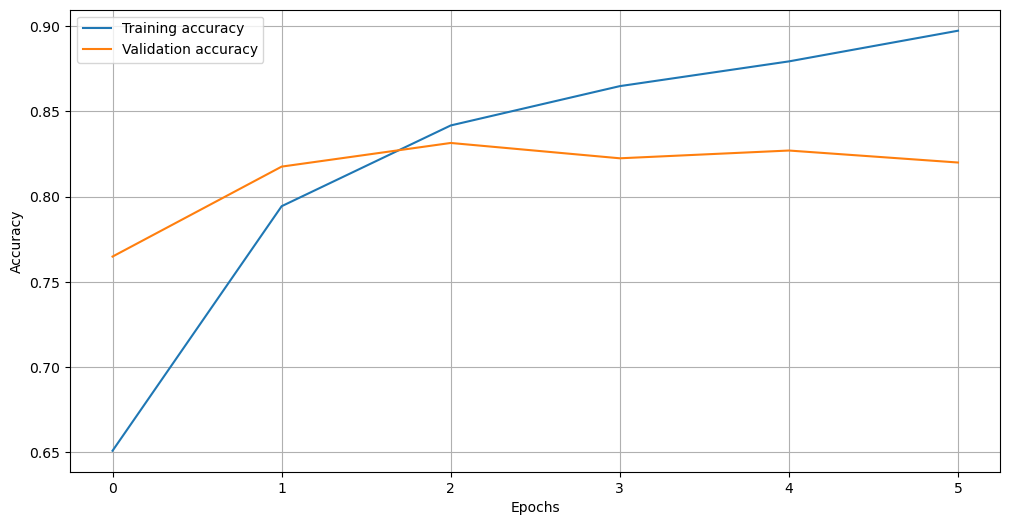

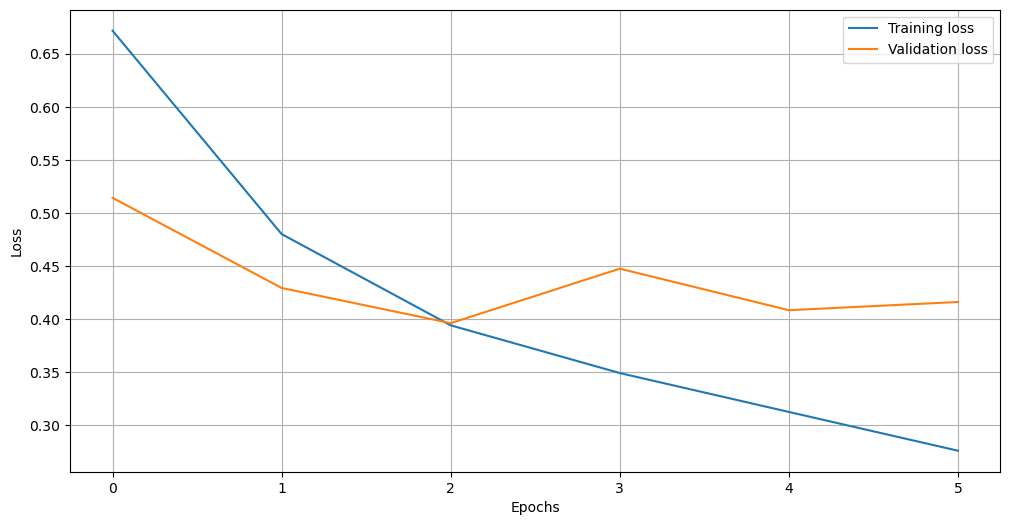

In [79]:
# Plot accuracy and loss
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

# Inference Code

In [81]:
# Function to predict the sentiment of a new review
def predict_review(review):
    # Convert review to sequence and pad it
    sequence = tokenizer.texts_to_sequences([review])
    padded_sequence = pad_sequences(sequence, maxlen=max_length, truncating=trunc_type)
    
    # Predict sentiment
    prediction = model.predict(padded_sequence)
    sentiment = 'positive' if prediction > 0.5 else 'negative'
    return sentiment

In [82]:
# Example prediction
new_review = "The movie was fantastic and full of thrilling moments!"
print(predict_review(new_review))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
positive
